In [1]:
import random
import torch
import d2l
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn


class LinearRegression(d2l.Module):
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)
        
    def forward(self, X):
        return self.net(X)
    
    def loss(self, y_hat, y):
        fn = nn.MSELoss(reduction='mean')
        return fn(y_hat, y)

/home/jovyan/work/d2l/notebooks/d2l.py:119: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self, 'net'), 'Neural network is defined'
/home/jovyan/work/d2l/notebooks/d2l.py:123: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self, 'trainer'), 'trainer is not inited'


(Parameter containing:
 tensor([[ 1.9981, -3.3884]], requires_grad=True),
 Parameter containing:
 tensor([4.1935], requires_grad=True))

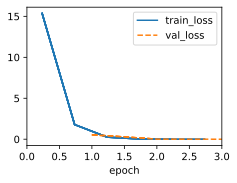

In [14]:
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
model = LinearRegression(lr=0.03)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)
model.net.weight,model.net.bias

# 3.5.6. Exercises

## 1. How would you need to change the learning rate if you replace the aggregate loss over the minibatch with an average over the loss on the minibatch?

When you calculate the average loss over the minibatch instead of the aggregate loss, the scale of the loss becomes smaller. As a result, the gradients used for parameter updates are also smaller. To compensate for this, you typically increase the learning rate to achieve similar step sizes for parameter updates.

The adjustment can be made by dividing the original learning rate by the batch size. This helps scale the gradients appropriately to match the change in loss scaling. 

In [15]:
class LinearRegressionAggLoss(d2l.Module):
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)
        
    def forward(self, X):
        return self.net(X)
    
    def loss(self, y_hat, y):
        fn = nn.MSELoss(reduction='sum')
        return fn(y_hat, y)

(Parameter containing:
 tensor([[ 1.9405, -3.4046]], requires_grad=True),
 Parameter containing:
 tensor([4.2016], requires_grad=True))

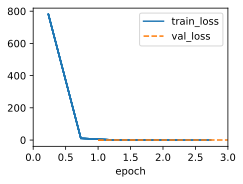

In [24]:
model = LinearRegressionAggLoss(lr=0.03)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)
model.net.weight,model.net.bias

(Parameter containing:
 tensor([[ 1.9954, -3.3869]], requires_grad=True),
 Parameter containing:
 tensor([4.1921], requires_grad=True))

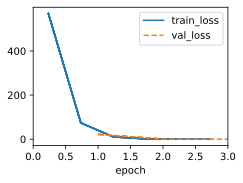

In [21]:
model = LinearRegressionAggLoss(lr=0.03/32)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)
model.net.weight,model.net.bias

## 2. Review the framework documentation to see which loss functions are provided. In particular, replace the squared loss with Huber’s robust loss function. That is, use the loss function

$L_{\delta}=
    \left\{\begin{matrix}
        \frac{1}{2}(y - \hat{y})^{2} & if \left | (y - \hat{y})  \right | < \delta\\
        \delta ((y - \hat{y}) - \frac1 2 \delta) & otherwise
    \end{matrix}\right.$


In [26]:
class LinearRegressionHuberLoss(d2l.Module):
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0,0.01)
        self.net.bias.data.fill_(0)
        
    def forward(self, X):
        return self.net(X)
    
    def loss(self, y_hat, y):
        fn = nn.HuberLoss()
        return fn(y_hat, y)

(Parameter containing:
 tensor([[ 2.0007, -3.4017]], requires_grad=True),
 Parameter containing:
 tensor([4.1984], requires_grad=True))

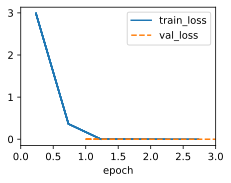

In [29]:
model = LinearRegressionHuberLoss(lr=0.3)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)
model.net.weight,model.net.bias

## 3. How do you access the gradient of the weights of the model?

In [31]:
model.net.weight.grad,model.net.bias.grad

(tensor([[-0.0023,  0.0042]]), tensor([0.0040]))

## 4. What is the effect on the solution if you change the learning rate and the number of epochs? Does it keep on improving?

We make some experienmts with lr in [0.003,0.03,0.3,3] with epoch=3

when lr is small (such as 0.003), the loss function drops very slow, and the error can be reduced by increasing epoch
when lr increases, the loss function drops faster, and if it convergences, increasing epoch will not help too.
when lr is much larger (such as 3), the loss function blows up, and there is no need to increase epoch

## 5. How does the solution change as you vary the amount of data generated?

* Plot the estimation error for $\hat{w}-w$ and $\hat{b}-b$ as a function of the amount of data. Hint: increase the amount of data logarithmically rather than linearly, i.e., 5, 10, 20, 50, …, 10,000 rather than 1000, 2000, …, 10,000.
* Why is the suggestion in the hint appropriate?

In [2]:
def stat_bias(n):
    w = torch.tensor([2, -3.4])
    b = torch.tensor([4])
    data = d2l.SyntheticRegressionData(w=w, b=b, num_train=n, num_val=n)
    model = LinearRegression(lr=0.03)
    trainer = d2l.Trainer(max_epochs=3, plot_flag=False)
    trainer.fit(model, data)
    bias_w = torch.abs(w-model.net.weight).detach().numpy()
    bias_b = torch.abs(b-model.net.bias).detach().numpy().reshape(1, -1)
    return np.concatenate([bias_w, bias_b], axis=1)

Logarithmic Growth Sequence: [5, 10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240]


/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/opt/conda/envs/d2l/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/d2l/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/d2l/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig()

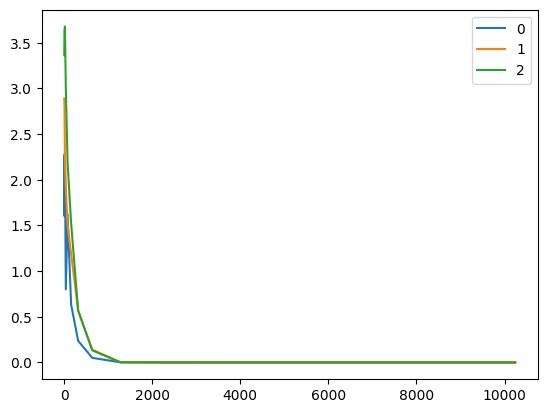

In [3]:
initial_value = 5
growth_factor = 2
num_elements = 12
# Generate the logarithmic growth sequence
nums = [initial_value * growth_factor**i for i in range(num_elements)]
print("Logarithmic Growth Sequence:", nums)
bias = np.empty((1, 3), dtype=float)
for i in range(len(nums)):
    temp = stat_bias(nums[i])
    bias = np.concatenate([bias, temp], axis=0)
for i in range(3):
    plt.plot(nums[:], bias[1:,i], label=i)
plt.legend()
plt.show()